# Build a model that can predict the score of a post on r/askscience given at least the title and body of the post (There is no need to limit it to just the title and body, but you must explain why you chose the features you did).



# Predicting the score:
    - The rationale to choose the features to train the regression models is detailed in the pivotal_askscience_EDA.ipynb.  
    - A preprocessed dataset generated in the pivotal_askscience_EDA.ipynb was used to train the models.
    - There are works in the literature that shows that reddit post titles and timing are important factors in the popularity of a post. They concluded that it is not necessarily clear that high scoring content is predictable. In fact, a recent study reports fairly low accuracy results.
        - A. Jaech, V. Zayats, H. Fang, M. Ostendorf, and H. Hajishirzi, “Talking to the crowd: What do people react to in online discussions?” arXiv preprint arXiv:1507.02205, 2015

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn_evaluation import plot

from nltk.corpus import stopwords

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau


#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

pd.set_option('display.max_colwidth', None)

# Load dataset from CSV already preprocessed.

In [20]:
# Load data
df = pd.read_csv('askscience_data_new_features.csv')
df['body_length'] = df['body_length'].fillna(0)
df['count_links'] = df['count_links'].fillna(0)
# Creating a new feature to check if tag exists or not.
df['has_tag'] = (df['tag'] == 'Unknown').astype(int)
df.shape

(3705, 24)

### Feature pre-processing


In [21]:

# Perform text vectorization. Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X_text = vectorizer.fit_transform(df['title_body_Lemmatized'])#+' '+df['tag'])

# Convert categorical variables into a one-hot encoded representation to represent them as a binary vectors.
one_hot_encoder = OneHotEncoder(sparse_output=False)
month_ohe = one_hot_encoder.fit_transform(df[['month']])
month_ohe_df = pd.DataFrame(month_ohe, columns=one_hot_encoder.get_feature_names_out(['month']))

year_ohe = one_hot_encoder.fit_transform(df[['year']])
year_ohe_df = pd.DataFrame(year_ohe, columns=one_hot_encoder.get_feature_names_out(['year']))

hour_ohe = one_hot_encoder.fit_transform(df[['hour_category']])
hour_ohe_df = pd.DataFrame(hour_ohe, columns=one_hot_encoder.get_feature_names_out(['hour_category']))

tag_ohe = one_hot_encoder.fit_transform(df[['tag']])
tag_ohe_df = pd.DataFrame(tag_ohe, columns=one_hot_encoder.get_feature_names_out(['tag']))


### Building and Normalizing the dataset for input.
 - The celll bellow builds the dataset to be used as input. We tested our prediction models in several combinations of the features we extracted. All these results are not shown here for the ake of clarity.
 - Only the final input is shown and is composed by the folllowing features: 
     - 'title_length', 'body_length', 'has_links', 'upvote_ratio', 'has_tag', year_ohe_df, and the vectorize Body text (X_text).


In [22]:

# Normalize the features
scaler = StandardScaler()
#numeric_df = pd.DataFrame(scaler.fit_transform(df[['most_important_words_Count', 'title_length', 'body_length', 'count_links', 'upvote_ratio']]), columns=['most_important_words_Count', 'title_length', 'body_length', 'has_links', 'upvote_ratio'])
numeric_df = pd.DataFrame(scaler.fit_transform(df[['title_length', 'body_length', 'count_links', 'upvote_ratio', 'has_tag']]), columns=['title_length', 'body_length', 'has_links', 'upvote_ratio', 'has_tag'])

X = pd.concat([year_ohe_df, pd.DataFrame(X_text.toarray()), numeric_df], axis=1)

# Convert all column names to strings
X.columns = X.columns.astype(str)

Y_normalized = pd.DataFrame(scaler.fit_transform(df[['score']]), columns=['label'])



## Random Forest Model for the regression tasks

In [27]:


# Split the data into a training set and a test set
#X_train, X_test, y_train, y_test = train_test_split(X, Y_normalized, test_size=0.2, random_state=42)

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_indx = {}
all_rmse = []
all_r2 = []
fold = 1
best_fold = 0
best_r2 = 0
best_rmse = float('inf')
best_model = None

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    fold_indx[fold]={'train_index':train_index, 'test_index':test_index}
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y_normalized.iloc[train_index], Y_normalized.iloc[test_index]
    
    # Train a random forest regressor
    model = RandomForestRegressor(n_estimators=80, random_state=42, verbose=100)
    model.fit(X_train, np.array(y_train).ravel())
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Check if this model has the lowest RMSE so far
    if r2 > best_r2:
        best_fold = fold
        best_r2 = r2
        best_rmse = rmse
        best_model = model

    fold += 1
    
    print(f'RMSE fold {fold}: {rmse:.4f}')
    print(f'R-Squared fold {fold}: {r2:.4f}')
    
# Use the best model for final evaluation
print(f'Best RMSE across folds     : {best_rmse:.4f}')
print(f'Best R-Squared across folds: {best_r2:.4f}')
print(f'Best fold: {best_fold}')


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 80
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
building tree 2 of 80
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
building tree 3 of 80
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
building tree 4 of 80
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.3s remaining:    0.0s
building tree 5 of 80
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.8s remaining:    0.0s
building tree 6 of 80
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.5s remaining:    0.0s
building tree 7 of 80
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.1s remaining:    0.0s
building tree 8 of 80
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.7s remaining:    0.0s
building tree 9 of 80
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   14.4s remaining:    0.0s
b

## Feature Importance
    - Random forest alllows us to check the importance of the features in the prediction.
    - Results are consistent with the exploratory data analisys (EDA), performed before:
        - As expected, "upvote_ratio" has a high importance in the prediction.
        - Some of the year features are also of high impact (e.g., 'year_2022', and 'year_2017')
        - 'title_length' and 'body_length' are also amongst the top 20 high impact features. 
    - Other high impact features are words that were vectorized from the body text.

In [32]:
# Get feature importance
importances = best_model.feature_importances_

# Convert the importances into a DataFrame
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

importances_df = importances_df[importances_df['Importance'] > 0.0001]

important_feat = importances_df.Feature

print(len(importances_df))
importances_df.head(20)

510


,Feature,Importance
13188,upvote_ratio,0.335328
12,year_2022,0.282904
6488,6475,0.019989
10599,10586,0.011422
8113,8100,0.011010
1739,1726,0.010149
798,785,0.009693
12965,12952,0.008062
8143,8130,0.007504
4772,4759,0.005999


## Neural Network Approach.
    - Can we do better than Random Forest?
    - Train a simple fully connect neural network.
    - Several combinations of the architecture and hyperparameters were tested, but bellow only the best model is shown.

In [33]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Network architecture
class DeepScorePredictor(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=.5):
        super(DeepScorePredictor, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
# Hyperparameters
input_size = X.shape[1]  
hidden_size = [256, 64, 128, 64]  
output_size = 1  
batch_size=128
dropout_prob = 0.5  
num_epochs = 40  
learning_rate = 0.0002 


### Training Loop with 5-fold cross-validation


In [34]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_indx = {}
all_rmse = []
all_r2 = []
fold = 1
best_fold = 0
best_r2 = 0
best_rmse = float('inf')
best_model = None

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    
    fold_indx[fold]={'train_index':train_index, 'test_index':test_index}
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y_normalized.iloc[train_index], Y_normalized.iloc[test_index]
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

    # Create DataLoader for training, validation, and testing sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    model = DeepScorePredictor(input_size, hidden_size, output_size, dropout_prob).to(device)

    # Define loss function and optimizer
    #criterion = nn.HuberLoss()
    #criterion = nn.L1Loss()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2) 
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-6, verbose=True)
    #scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce learning rate by a factor of 0.1 every 10 epochs

    # Train the model
    num_epochs = 80
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move input data to GPU
            # Forward pass
            outputs = model(inputs)
            # Reshape target to match the shape of outputs
            targets = targets.view(-1, 1)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

    # Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_loss = 0.0
        y_test_pred = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            total_loss += loss.item()
            y_test_pred.extend(outputs.cpu().numpy())

        average_loss = total_loss / len(test_loader)
        y_test_true = y_test_tensor.cpu().numpy()
        rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
        r2 = r2_score(y_test_true, y_test_pred)

        
    y_test_true = y_test_tensor.cpu().numpy()
    rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    r2 = r2_score(y_test_true, y_test_pred)
    all_rmse.append(rmse)
    all_r2.append(r2)
    print(f'Fold {fold}: RMSE = {rmse:.4f}, R-Squared: {r2:.4f}')

    # Check if this model has the lowest RMSE so far
    if r2 > best_r2:
        best_fold = fold
        best_r2 = r2
        best_rmse = rmse
        best_model = model.state_dict()

    fold += 1

print()
# Use the best model for final evaluation
print(f'Best RMSE across folds     : {best_rmse:.4f}')
print(f'Best R-Squared across folds: {best_r2:.4f}')
print(f'Best fold: {best_fold}')

# Save the final trained model ================================================
torch.save(best_model, 'best_model_kfold.pth')


Epoch 1, Loss: 0.5639516711235046
Epoch 2, Loss: 0.9072427749633789
Epoch 3, Loss: 1.8003774881362915
Epoch 4, Loss: 1.018221139907837
Epoch 5, Loss: 0.3843970000743866
Epoch 6, Loss: 0.6216168403625488
Epoch 7, Loss: 0.5375160574913025
Epoch 8, Loss: 0.49659833312034607
Epoch 9, Loss: 1.0635241270065308
Epoch 10, Loss: 0.07695802301168442
Epoch 11, Loss: 0.19794003665447235
Epoch 12, Loss: 0.2314300835132599
Epoch 13, Loss: 0.2448045313358307
Epoch 14, Loss: 0.2066171020269394
Epoch 15, Loss: 0.10775374621152878
Epoch 16, Loss: 0.08002316206693649
Epoch 17, Loss: 0.04920295998454094
Epoch 18, Loss: 0.03787486255168915
Epoch 19, Loss: 0.42340126633644104
Epoch 20, Loss: 0.20118990540504456
Epoch 21, Loss: 0.12534070014953613
Epoch 22, Loss: 0.5091542601585388
Epoch 23, Loss: 0.19662874937057495
Epoch 24, Loss: 0.10942333191633224
Epoch 25, Loss: 0.12882910668849945
Epoch 26, Loss: 0.20380763709545135
Epoch 27, Loss: 1.3980470895767212
Epoch 28, Loss: 0.27877068519592285
Epoch 29, Loss:

In [35]:

all_r2, all_rmse

([0.6323991476573523,
  0.7362138895122097,
  0.5463273881673827,
  0.73624371302535,
  0.6652673044277756],
 [0.5894654, 0.4788243, 0.751689, 0.46508485, 0.6098596])


# Load the model for inference

In [36]:

loaded_model = DeepScorePredictor(input_size, hidden_size, output_size).to(device)
loaded_model.load_state_dict(torch.load('best_model_kfold.pth'))

X_test = X.iloc[fold_indx[best_fold]['test_index']]
y_test = Y_normalized.iloc[fold_indx[best_fold]['test_index']]

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
# Evaluate the model on test set
loaded_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    total_loss = 0.0
    y_test_pred = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = loaded_model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        total_loss += loss.item()
        y_test_pred.extend(outputs.cpu().numpy())

    average_loss = total_loss / len(test_loader)
    y_test_true = y_test_tensor.cpu().numpy()
    test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    test_r2 = r2_score(y_test_true, y_test_pred)
    print(f'Final Test Loss: {average_loss:.4f}, Test RMSE: {test_rmse:.4f}, Test R-Squared: {test_r2:.4f}')
    # Without the outliers: Final Test Loss: 0.2398, Test RMSE: 0.4544, Test R-Squared: 0.7764


Final Test Loss: 0.2442, Test RMSE: 0.4651, Test R-Squared: 0.7362


# Quantitative comparison between both models, Random Forest and the FC NN yields simillar results.

- Best Random Forest Fold RMSE: **0.4619**
- Best Random Forest Fold R-Squared: **0.7399**
    
- Best FC NN Fold RMSE: **0.4651**
- Best FC NN Fold R-Squared: **0.7362**
    
    
    

## Visualizing results
    - Quantitative metrics are very similar for both models and so are the plots of residuals and BA-plot. Showing only for the FCNN.
    - 5 outliers with very high socres are hurting the performance of the model and decreasing the R2 metric.
    - A histogram of the residuals show a distributiion centered in zero and not spread out, limited to small values. The residuals plot show a similar result.
    - Finally the Bland Altman plot show bias very close to zero and a small mean difference between truth and predictions.

Results of sklearn.metrics:
MAE: 0.2290815
MSE: 0.21630391
RMSE: 0.46508485
R-Squared: 0.73624371302535


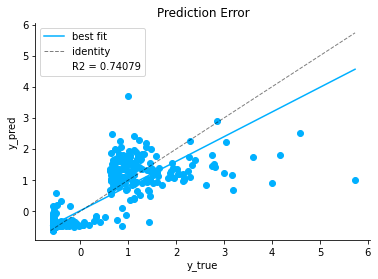

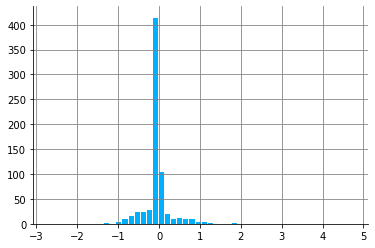

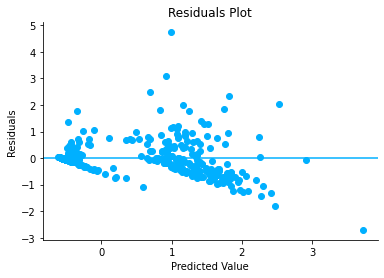

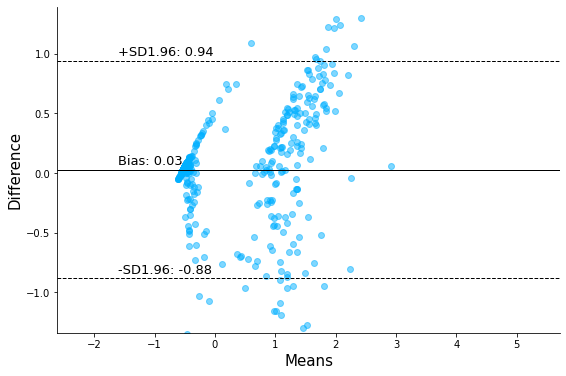

In [46]:

# Assuming y_test are your true target values and y_pred are the predicted values
y_test_true = np.array(y_test_true).squeeze()
y_test_pred = np.array(y_test_pred).squeeze()

mae = metrics.mean_absolute_error(y_test_true, y_test_pred)
mse = metrics.mean_squared_error(y_test_true, y_test_pred)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test_true, y_test_pred)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

plot.prediction_error(np.array(y_test_true), y_test_pred)
plt.show()
# =============================

d = {'diff' : (np.array(y_test_true)-y_test_pred).ravel()}

dif = pd.DataFrame(d)
dif['diff'].hist(bins=50)
plt.show()

# =============================

plot.residuals((y_test_true), y_test_pred)
plt.show()

def bland_altman_plot(predicted, truth):
    mean_diff = (predicted-truth).mean()
    diff_range = (predicted-truth).std()*1.96

    plt.figure(figsize = (9,6))

    plt.scatter(predicted, predicted-truth, alpha=.5)

    plt.hlines(mean_diff, predicted.min()-2, predicted.max()+2, color="k", linewidth=1)
    plt.text(
        predicted.min()-1, mean_diff+.05*diff_range, "Bias: %.2f"%mean_diff,
        fontsize=13, 
    )

    plt.hlines(
        [mean_diff+diff_range, mean_diff-diff_range],
        predicted.min()-2, predicted.max()+2, color="k", linewidth=1,
        linestyle="--"
    )
    plt.text(
        predicted.min()-1, mean_diff+diff_range+.05*diff_range, 
        "+SD1.96: %.2f"%(mean_diff+diff_range),
        fontsize=13, 
    )
    plt.text(
        predicted.min()-1, mean_diff-diff_range+.05*diff_range, 
        "-SD1.96: %.2f"%(mean_diff-diff_range),
        fontsize=13, 
    )

    plt.xlim(predicted.min()-2, predicted.max()+2)
    plt.ylim(mean_diff-diff_range*1.5, mean_diff+diff_range*1.5)
    plt.xlabel("Means", fontsize=15)
    plt.ylabel("Difference", fontsize=15)

    plt.show()

bland_altman_plot(y_test_pred, y_test_true)
plt.show()


## Feature Importance FCNN
    - We can also check the importance of the features in the prediction from the FCNN.
    - Results are again consistent with the exploratory data analisys (EDA), performed before:
        - As expected, "upvote_ratio" has a high importance in the prediction.
        - Also like in the Random Forest approach some of the year features are also of high impact.
    - Other high impact features are words that were vectorized from the body text.

In [50]:
# Extract model parameters (weights)
params = model.state_dict()
# Extract the coefficients (weights) and feature names
feature_names = X.columns

coefficients = params['model.0.weight'].cpu().numpy()  # Change 'model.0.weight' if the layer index is different
coefficients = np.mean(coefficients, axis=0)

# Create a DataFrame to store feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of coefficients to identify important features
feature_importance_df['Abs_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display the top features by coefficient magnitude
print(feature_importance_df.head(20))

            Feature  Coefficient  Abs_Coefficient
13188  upvote_ratio    -0.017186         0.017186
8143           8130     0.011124         0.011124
10199         10186     0.010475         0.010475
8113           8100     0.010292         0.010292
6488           6475     0.010176         0.010176
12        year_2022     0.009916         0.009916
4843           4830     0.009672         0.009672
7         year_2017     0.009420         0.009420
1068           1055     0.008697         0.008697
10795         10782     0.008264         0.008264
8049           8036     0.008160         0.008160
1739           1726     0.008082         0.008082
10005          9992     0.007993         0.007993
4772           4759     0.007919         0.007919
9517           9504     0.007586         0.007586
2128           2115     0.007456         0.007456
9332           9319     0.007283         0.007283
5753           5740     0.007105         0.007105
10599         10586     0.006947         0.006947


In [21]:
params.keys()

odict_keys(['model.0.weight', 'model.0.bias', 'model.3.weight', 'model.3.bias', 'model.6.weight', 'model.6.bias', 'model.9.weight', 'model.9.bias', 'model.12.weight', 'model.12.bias'])

# Conclusions and future directions:

 - Both models were trained with 5-fold cross-validation and present similar results.
 - Outliers hurt the performance of the models. If we filter the outliers with "df = df[df.score<50000].reset_index()" the performance of the FC network for example goes from R2 of .73 to .76. Still we did not fillter the outliers in the results above.
 - With more time we could try different architectures, more broad grid search and hyperparemeter tunning.
 - Literature review shows that gramatics and linguistics have impact in the quality of the posts and its score. A LLM or other NLP models could be used to extract these features.
